In [95]:
import plotly.express as px
import numpy as np
from collections import defaultdict
import pandas as pd

px.defaults.width = 1000
px.defaults.height = 600

In [26]:
def pa1_bound(N,n,T,q,beta, delta, epsilon):
    den = n * epsilon
    num = np.sqrt(np.log(N)) * np.log(q*T/beta) * np.sqrt(np.log(1/delta))
    return np.sqrt(num/den)

In [69]:
def pa2_bound(N,n,T,q,beta, delta, epsilon):
    den = T * n * epsilon
    k = np.log(T)
    num = np.sqrt(np.log(N)) * np.log(q*T/beta) * np.log(2 * k / delta) * 2 * np.sqrt(2 * k * np.log(2/delta))
    return np.sqrt(num/den)

In [70]:
def pmwg_bound(N,n,T,q,beta, delta, epsilon):
    den = T * n * epsilon
    # num = np.sqrt(np.log(T*N*n)) * (np.log(q*n*T*T/beta)) * np.sqrt(np.log(1/delta))
    num = np.sqrt(np.log(T*N*n)) * (np.log(q*n*T*T/beta) - np.sqrt(T)) * np.sqrt(np.log(1/delta))
    # TODO: separate the first block from the following ones (warmup -> no negative accuracy bound)
    return np.sqrt(num/den)

In [71]:
bounds = {
    "pmwg": pmwg_bound,
    "one_pmw_per_block": pa1_bound,
    "tree_of_pmws": pa2_bound,
}   

In [76]:
delta = 1e-6
epsilon = 0.5
n = 1000
q = 100
N = 2**5
T = 100
beta = 0.01

In [86]:
d = defaultdict(list)
size_dict = defaultdict(list)
for T in np.linspace(2,1000, num=10):
    for e in [1,0.9, 0.5]:
        size_dict["exponent_size_limit"].append(e)
        size_dict["n_blocks"].append(T)
        size_dict["max_n_requested_blocks"].append(T**e)
        for n in np.linspace(100, 1000, num=10):
            for algo, bound in bounds.items():

                    scaling = 1 if algo == "pmwg" else T**(e-1)
                    d["algo"].append(algo)
                    d["error"].append(
                        scaling * bound(N,n,T,q,beta, delta, epsilon)
                    )
                    d["block_size"].append(n)
                    d["n_blocks"].append(T)
                    d["exponent_size_limit"].append(e)
df = pd.DataFrame(d)
size_df = pd.DataFrame(size_dict)

/tmp/ipykernel_2633045/1214529332.py:6: RuntimeWarning:

invalid value encountered in sqrt



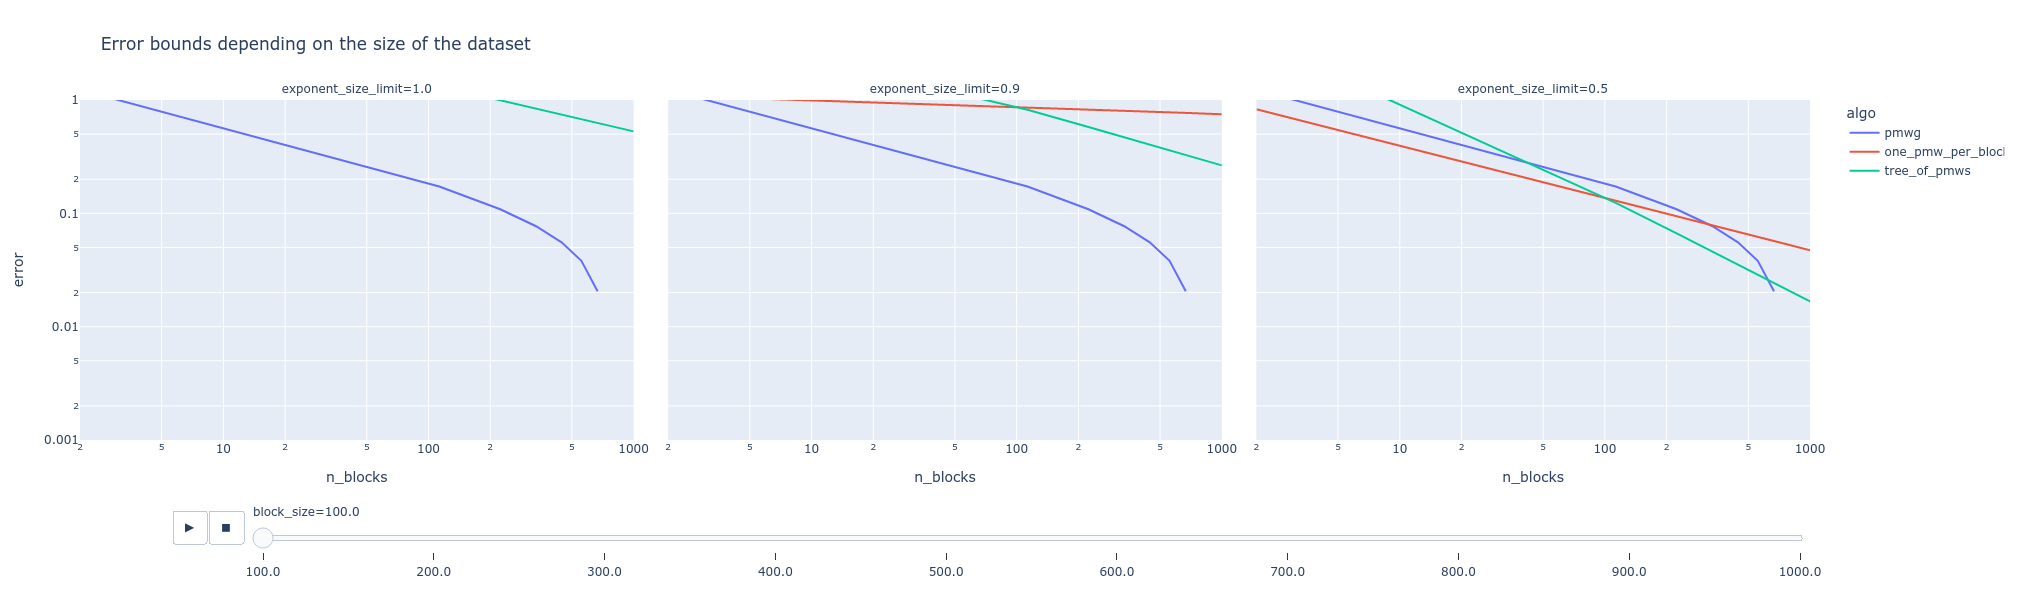

In [96]:
px.line(
    df,
    x="n_blocks",
    y="error",
    color="algo",
    animation_frame="block_size",
    range_y=[1e-3,1],
    facet_col="exponent_size_limit",
    log_y=True,
    log_x=True,
    title="Error bounds depending on the size of the dataset",
)
    

## Caveats when reading the error bounds
- Theorems gives asymptotic guarantees, so the real bounds might be shifted up or down by large factors. You should focus on the slope and the evolution of the curve when we change parameters.
- There are a lot of moving pieces, I fixed some of them arbitrarily.
- PMWG has a strange $-\sqrt{T}$ factor in the accuracy bound that gives negative error for large number of blocks when some assumptions are not respected. Maybe it will help if I separate the "initial number of blocks" from the "online blocks" like they do.
- My error bounds are probably not tight and encapsulate a few assumptions. In particular, Tree of PMWs can be optimized further.
- The error bound is a worst-case error (max_q |pmw_output - true_output|). Block PMWs can give different guaranties for different queries, depending on the number of blocks they request.

## Interpretation
- When queries can request all the blocks, PMWGs is still the best. Tree of PMWs is pretty close though (almost parallel slope). One PMW per Block scales very poorly, because queries requesting a lot of blocks will need a linear number of PMWs (instead of logarithmic). 
- Tree of PMWs has the most negative slope when we limit the number of requested blocks, e.g. with exponent 0.5 (i.e. a query can request at most sqrt of the total number of blocks).
- One PMW per Block is surprisingly efficient for small number of blocks, probably because it doesn't deal with as much overhead as PMWG or Tree of PMWs.

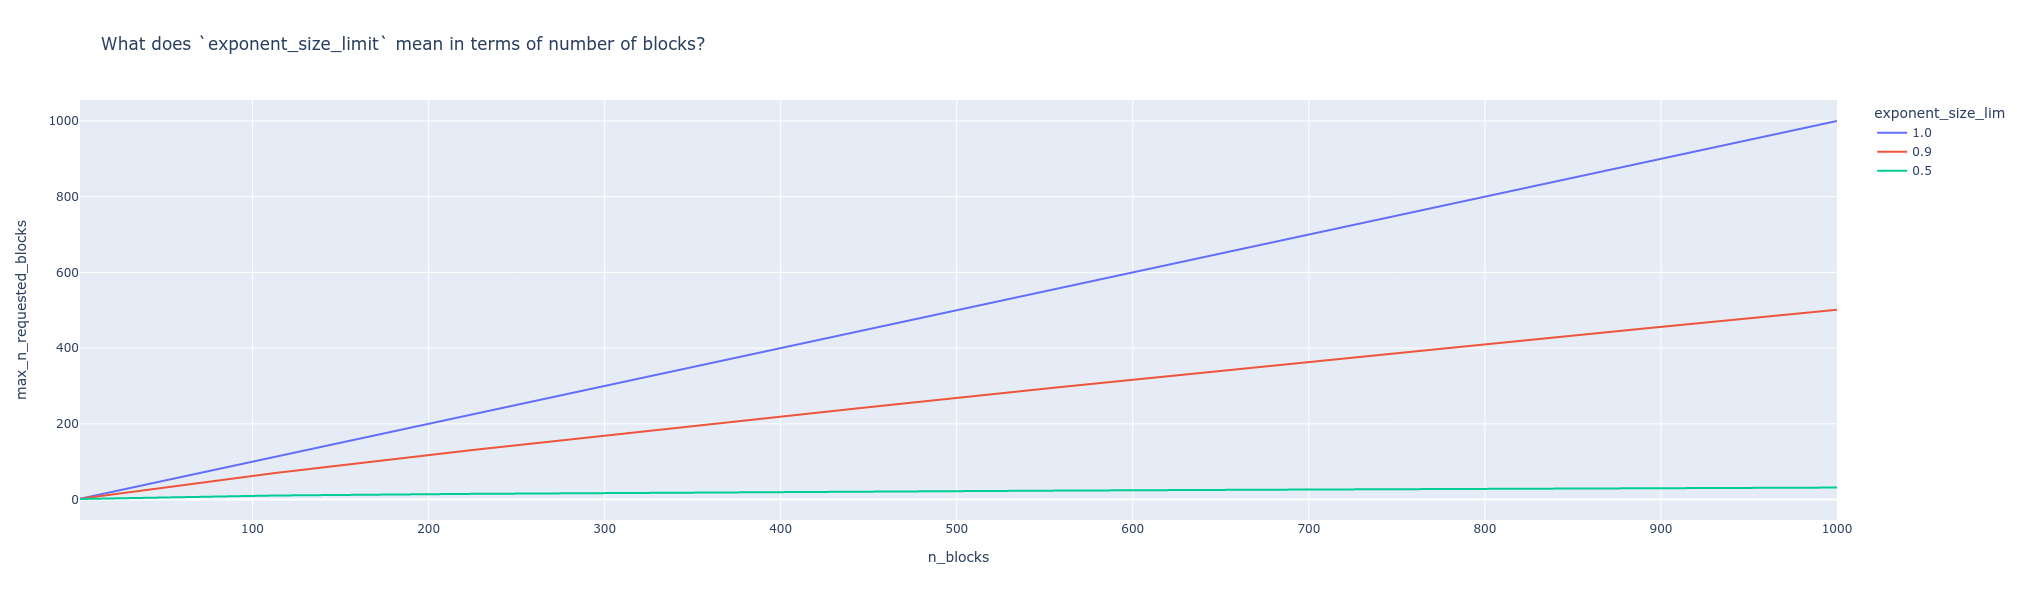

In [97]:
px.line(
    size_df,
    x="n_blocks",
    y="max_n_requested_blocks",
    color="exponent_size_limit",
    title="What does `exponent_size_limit` mean in terms of number of blocks?"
)
    